# Import Library

In [1]:
import pathlib
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
DATASET_PATH = 'dataset'
data_dir = pathlib.Path(DATASET_PATH)

# Data Splitting

In [3]:
train_dataset, val_dataset = tf.keras.utils.audio_dataset_from_directory(
    batch_size=64,
    seed=0,
    directory=data_dir,
    subset="both",
    validation_split=0.3,
    output_sequence_length=16000,
)

Found 6505 files belonging to 4 classes.
Using 4554 files for training.
Using 1951 files for validation.


In [4]:
label_names = np.array(train_dataset.class_names)
print (label_names)
num_label = len(label_names)
print (num_label)

['follow' 'learn' 'tree' 'visual']
4


# Squeezing

In [6]:
def squeeze(audio, label):
    audio = tf.squeeze(audio, axis=-1)
    return audio, label

In [7]:
train_dataset = train_dataset.map(squeeze, tf.data.AUTOTUNE)
val_dataset = val_dataset.map(squeeze, tf.data.AUTOTUNE)

# Get Test Dataset

In [8]:
test_dataset = val_dataset.shard(num_shards=2, index=0)
val_dataset = val_dataset.shard(num_shards=2, index=1)

# Generate Spectogram

In [9]:
def get_spectogram(waveform):
    spectogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    spectogram = tf.abs(spectogram)
    spectogram = spectogram[..., tf.newaxis]
    return spectogram

In [10]:
def make_spec_ds(ds):
    return ds.map(
        map_func = lambda audio, label : (get_spectogram(audio), label),
        num_parallel_calls = tf.data.AUTOTUNE
    )

# Converting Audio dataset to Spectogram

In [11]:
train_spectogram_ds = make_spec_ds(train_dataset)
val_spectogram_ds = make_spec_ds(val_dataset)
test_spectogram_ds = make_spec_ds(test_dataset)

In [12]:
train_spectogram_ds = train_spectogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectogram_ds = val_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectogram_ds = test_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [13]:
train_spectogram_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Build Model

In [14]:
for exmp_spectogram, exmp_spectogram_label in train_spectogram_ds.take(1):
    break

In [15]:
input_shape = exmp_spectogram.shape[1:]

In [16]:
norm_layer = layers.Normalization()
norm_layer.adapt(
    data=train_spectogram_ds.map(
        map_func = lambda spec, label : spec
    )
)

In [20]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_label)
])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,375 (1.20 MB)

 Trainable params: 314,372 (1.20 MB)

 Non-trainable params: 3 (16.00 B)

In [22]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)

# Train Model

In [23]:
EPOCHS=10

history = model.fit(
    train_spectogram_ds,
    validation_data=val_spectogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(
        verbose=1, patience=2
    )
)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.5497 - loss: 1.0498 - val_accuracy: 0.7979 - val_loss: 0.5966
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7898 - loss: 0.5882 - val_accuracy: 0.8229 - val_loss: 0.4728
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8364 - loss: 0.4673 - val_accuracy: 0.8635 - val_loss: 0.3963
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8780 - loss: 0.3705 - val_accuracy: 0.8823 - val_loss: 0.3519
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8921 - loss: 0.3220 - val_accuracy: 0.9042 - val_loss: 0.2994
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9114 - loss: 0.2613 - val_accuracy: 0.9042 - val_loss: 0.2866
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9231 - loss: 0.2375 - val_accuracy: 0.9010 - val_loss: 0.3071
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9299 - loss: 0.2190 - val_accuracy: 0.9104 - v

# Evalauate Model

Text(0, 0.5, 'Accuracy [%]')

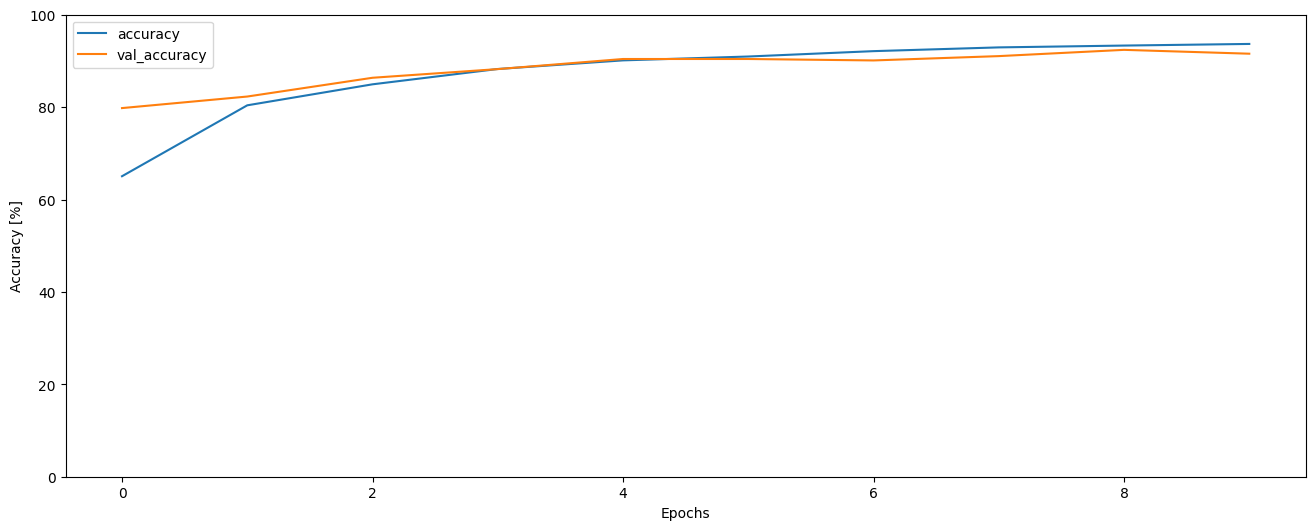

In [25]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.plot(history.epoch, 100*np.array(metrics["accuracy"]), 100*np.array(metrics["val_accuracy"]))
plt.legend(["accuracy", "val_accuracy"])
plt.ylim(0,100)
plt.xlabel("Epochs")
plt.ylabel("Accuracy [%]")

In [24]:
test_results = model.evaluate(test_spectogram_ds, return_dict=True)
accuracy = test_results["accuracy"]
print (f"Model Accuracy on Test Dataset : {accuracy*100:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9181 - loss: 0.2129
Model Accuracy on Test Dataset : 92.03


# Predict

In [26]:
counter = 0

for i, (spectogram, label) in enumerate (test_spectogram_ds):

    pred = model.predict(spectogram)

    pred_label_idx = tf.argmax(pred, axis=1).numpy()

    orig_label = label_names[label.numpy()]

    pred_label = [label_names[idx] for idx in pred_label_idx]

    for j, label in enumerate (orig_label):
        counter += 1
        print (f"Data {counter}. Original : {label} -> Prediction : {pred_label[j]}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Data 1. Original : tree -> Prediction : tree
Data 2. Original : learn -> Prediction : learn
Data 3. Original : tree -> Prediction : tree
Data 4. Original : tree -> Prediction : tree
Data 5. Original : tree -> Prediction : tree
Data 6. Original : visual -> Prediction : visual
Data 7. Original : tree -> Prediction : tree
Data 8. Original : visual -> Prediction : visual
Data 9. Original : learn -> Prediction : learn
Data 10. Original : visual -> Prediction : visual
Data 11. Original : visual -> Prediction : visual
Data 12. Original : follow -> Prediction : follow
Data 13. Original : learn -> Prediction : learn
Data 14. Original : tree -> Prediction : tree
Data 15. Original : tree -> Prediction : tree
Data 16. Original : visual -> Prediction : visual
Data 17. Original : tree -> Prediction : tree
Data 18. Original : tree -> Prediction : tree
Data 19. Original : tree -> Prediction : tree
Data 20. Original : follow -> Prediction : follow
Data 21. Original